1 Binary Logistic Regression

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

In [9]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9963575118259986


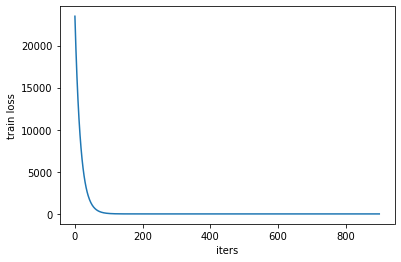

In [10]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    @staticmethod
    def sigmoid(pred):
        return 1.0 / (1 + np.exp(-pred))
    
    def calculate_loss(self, y_pred, batch_X, batch_y):
        loss = -batch_y * np.log(y_pred) - (1 - batch_y) * np.log(1 - y_pred)
        return loss.sum() / batch_X.shape[0] + (self.llambda / 2) * self.w.T.dot(self.w)
        
    def fit(self, X, y):
        np.random.seed(42)
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j + self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
                
                y_pred = self.predict_proba(batch_X)
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                loss = self.calculate_loss(y_pred, batch_X, batch_y)
                dy = y_pred - batch_y
                
                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_w = (1 / batch_X.shape[1]) * batch_X.T.dot(dy) + self.llambda * self.w
                grad_b = (1 / batch_X.shape[1]) * np.sum(dy)

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        pred = X.dot(self.w) + self.b
        return self.sigmoid(pred)
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda=3, lr=0.01, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

Multinomial Logistic Regression using pytorch


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = F.sigmoid(torch.matmul(x, self.W) + self.b)
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

implement early stopping using early_stopping_patience

In [0]:
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if len(history['valid']) > early_stopping_patience:
            if non_decreasing(history['valid'][-early_stopping_patience:]):
                return history
    return history

predict hard labels

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = torch.argmax(model(batch_x), dim=1)
            result.append(pred)
    return np.concatenate(result)

In [17]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



train loss: 3.016 valid loss:2.998



train loss: 2.992 valid loss:2.977



train loss: 2.971 valid loss:2.959



train loss: 2.952 valid loss:2.943



train loss: 2.935 valid loss:2.927



train loss: 2.917 valid loss:2.911



train loss: 2.901 valid loss:2.896



train loss: 2.884 valid loss:2.882



train loss: 2.869 valid loss:2.868



train loss: 2.854 valid loss:2.855



train loss: 2.839 valid loss:2.843



train loss: 2.826 valid loss:2.831



train loss: 2.813 valid loss:2.819



train loss: 2.802 valid loss:2.809



train loss: 2.789 valid loss:2.799



train loss: 2.779 valid loss:2.789



train loss: 2.768 valid loss:2.780



train loss: 2.759 valid loss:2.772



train loss: 2.750 valid loss:2.764



train loss: 2.741 valid loss:2.757



train loss: 2.733 valid loss:2.750



train loss: 2.726 valid loss:2.743



train loss: 2.719 valid loss:2.737



train loss: 2.712 valid loss:2.731



train loss: 2.706 valid loss:2.726



train loss: 2.700 valid loss:2.721



train loss: 2.695 valid loss:2.716



train loss: 2.689 valid loss:2.712



train loss: 2.684 valid loss:2.708



train loss: 2.679 valid loss:2.704



train loss: 2.675 valid loss:2.700



train loss: 2.671 valid loss:2.697



train loss: 2.668 valid loss:2.693



train loss: 2.664 valid loss:2.691



train loss: 2.660 valid loss:2.688



train loss: 2.658 valid loss:2.685



train loss: 2.655 valid loss:2.682



train loss: 2.651 valid loss:2.680



train loss: 2.649 valid loss:2.678



train loss: 2.647 valid loss:2.676



train loss: 2.643 valid loss:2.674



train loss: 2.642 valid loss:2.672



train loss: 2.640 valid loss:2.671



train loss: 2.638 valid loss:2.669



train loss: 2.636 valid loss:2.667



train loss: 2.634 valid loss:2.666



train loss: 2.633 valid loss:2.664



train loss: 2.631 valid loss:2.663



train loss: 2.630 valid loss:2.662



train loss: 2.629 valid loss:2.661



train loss: 2.627 valid loss:2.660



train loss: 2.626 valid loss:2.659



train loss: 2.625 valid loss:2.658



train loss: 2.624 valid loss:2.657



train loss: 2.623 valid loss:2.656



train loss: 2.622 valid loss:2.656



train loss: 2.621 valid loss:2.655



train loss: 2.620 valid loss:2.654



train loss: 2.619 valid loss:2.653



train loss: 2.618 valid loss:2.653



train loss: 2.618 valid loss:2.652



train loss: 2.617 valid loss:2.652



train loss: 2.617 valid loss:2.651



train loss: 2.615 valid loss:2.651



train loss: 2.615 valid loss:2.650



train loss: 2.614 valid loss:2.650



train loss: 2.614 valid loss:2.649



train loss: 2.614 valid loss:2.649



train loss: 2.613 valid loss:2.649



train loss: 2.613 valid loss:2.648



train loss: 2.612 valid loss:2.648



train loss: 2.612 valid loss:2.648



train loss: 2.611 valid loss:2.647



train loss: 2.611 valid loss:2.647



train loss: 2.611 valid loss:2.647


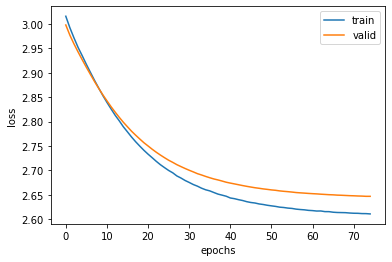

In [18]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [19]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.7574349442379182

What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [20]:
randommed_y_pred = np.random.uniform(0, 1, (len(y_test), 20))
criterion( torch.tensor(randommed_y_pred), torch.tensor(y_test))

tensor(3.0340, dtype=torch.float64)

What is the accuracy of constant prediction classifier for this task? [0.5 point]


In [21]:
metrics.accuracy_score(y_test, [1] * len(y_test))

0.05164630908125332